In [7]:
import os.path

from DataPreprocessor import preprocess
import pandas as pd
from OpenAiWrapper import OpenAiWrapper
import Utils
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import spacy
from ast import literal_eval
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import seaborn as sns
from wordcloud import WordCloud
import json

Utils.openAi_api_key = None # replace with OpenAI Key # - Don't push file with key!!

api = OpenAiWrapper()


df = pd.read_csv('../dataframes/praw_hot_submissions_preprocessed.csv', converters={Utils.col_title_tokens: literal_eval})

def replaceNan(x):
    if x == np.nan:
        return list()
    else:
        return x

# df[Utils.col_title_tokens] = df[Utils.col_title].apply(preprocess)
vectorizer = TfidfVectorizer()
df[Utils.col_title_token_string] = df[Utils.col_title_token_string].replace(np.nan, '')
df[Utils.col_title_tokens] = df[Utils.col_title_tokens].apply(replaceNan)
X = vectorizer.fit_transform(df[Utils.col_title_token_string].tolist())

nlp = spacy.load('en_core_web_md')
vectors = []
#for name in vectorizer.get_feature_names():
#    vectors.append(nlp(name).vector)

#embeddings = pd.DataFrame(columns=['token', 'embedding'])
#embeddings['token'] = vectorizer.get_feature_names()
#embeddings['embedding'] = vectors

#embeddings.set_index('token', inplace=True)
#embeddings.head()
if os.path.exists('../dataframes/embeddings_hot.csv'):
    openAi = OpenAiWrapper()
    print(len(vectorizer.get_feature_names()))
    print(vectorizer.get_feature_names()[2045:2050])
    vectors = openAi.getEmbeddingVector(vectorizer.get_feature_names())
    vectors.to_csv('../dataframes/embeddings_hot.csv')
else:
    vectors = pd.read_csv('../dataframes/embeddings_hot.csv')
    vectors['embedding'] = vectors['embedding'].apply(lambda x: json.loads(x))

vectors.head()

print("done")

3658
['meddles', 'media', 'medical', 'medication', 'medicine']
done


In [10]:
def embedd_submissions(x):
    sum = np.zeros(1536)
    if len(x) <= 0:
        return sum
    for token in x:
        if token.lower() in vectors.index:
            sum += vectors.loc[token.lower()]['embedding'][0]

    return sum / len(x)

df['embedded_submission'] = df[Utils.col_title_tokens].apply(embedd_submissions)
df['embedded_submission'].head()

0    [-0.008772569863746563, -0.0037856553244637325...
1    [-0.0051598050282336775, -0.004161568463314324...
2    [-0.005939735875775416, -0.006568237052609523,...
3    [-0.004254385642707348, -0.005871222168207168,...
4    [-0.00504483607558844, -0.00586156130884774, -...
Name: embedded_submission, dtype: object

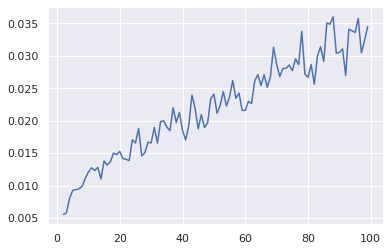

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns

#clustering with tfidf values

tfidfs = X.toarray()
cluster_range = range(2,100)
scores = []

for k in cluster_range:
    model = KMeans(n_clusters=k)
    fit = model.fit(tfidfs)
    score = silhouette_score(X, model.labels_, metric='cosine')
    scores.append(score)


sns.set()
plt.plot(cluster_range, scores)


In [16]:
k = 100
model = KMeans(n_clusters=k)
model.fit(tfidfs)
model.labels_

array([25, 39, 19, 52,  3, 44,  7, 10, 72, 41, 29, 14, 43, 52, 89, 64, 33,
       54, 72, 78, 25, 92,  6, 34, 97, 33, 67, 19, 44, 50, 99, 88, 51, 37,
       57, 53, 92, 25, 61, 37, 74, 67, 83, 61, 50, 81, 43, 46,  1, 58, 53,
       68, 38, 24, 99, 51, 36, 56,  7, 11,  1, 23, 63, 92,  4, 40, 48, 21,
       22, 89, 74, 23,  9,  8, 49, 10, 34, 36, 18, 52, 29,  4, 94, 65,  2,
       30, 12, 33, 29, 41, 30,  7, 19, 84, 26, 16,  1, 86, 80,  6,  6, 80,
       55, 42, 22,  2, 82, 77, 16, 44, 20, 39, 36, 79, 10, 15,  9, 43, 90,
        1, 93,  5, 36, 36, 27,  1, 20, 29, 26, 25, 91, 24, 65, 82, 10, 56,
       18, 56, 34, 88, 93, 52, 44,  2, 90,  8, 58, 72, 92,  6, 37, 78,  1,
       35, 91, 25,  0, 68, 32, 61, 50,  0,  5, 98, 91, 57, 47, 85, 24, 26,
       22, 93, 33, 60,  4,  1,  8, 19, 12, 64,  7, 28, 83, 44, 75, 82, 99,
       65, 12, 29, 89, 17, 33, 34, 94, 34, 52, 18, 30, 97,  7, 91, 20, 32,
       68, 54, 59,  5, 48, 64, 16,  4,  4, 18,  1, 69, 18,  0, 19, 97, 60,
       29, 45, 35, 33,  6

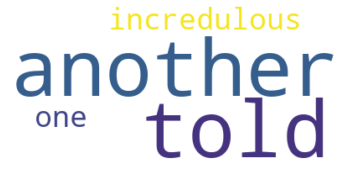

In [14]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy
    return np.where(labels_array == clustNum)[0]

from wordcloud import WordCloud

cluster2 = ClusterIndicesNumpy(12, model.labels_)
token_list = []
for postId in cluster2:
    post = df.iloc[postId]['title_tokens']
    for token in post:
        token_list.append(token.lower())

text = ' '.join(token_list)
wordcloud = WordCloud(background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

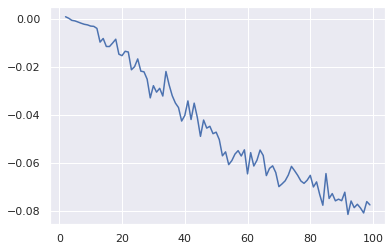

In [11]:
# clustering with embeddings
test = np.zeros((len(df),1536))
for docidx in range(len(df)):
    test[docidx] = df['embedded_submission'][docidx]

cluster_range = range(2,100)
scores = []

for k in cluster_range:
    model = KMeans(n_clusters=k)
    fit = model.fit(test)
    score = silhouette_score(X, model.labels_, metric='cosine')
    scores.append(score)


sns.set()
plt.plot(cluster_range, scores)

In [12]:
k = 100
model = KMeans(n_clusters=k)
model.fit(test)
model.labels_

array([ 0,  1,  3, 58,  3, 58, 47,  3, 87, 16, 59, 57, 58, 27, 18, 27, 87,
       86, 18, 71, 22,  4,  3, 77, 27,  7, 71, 37, 58,  7, 58,  7, 87, 87,
       22,  4, 97, 16,  3, 31, 27, 21, 50,  1, 52, 47, 22, 27,  7, 47, 27,
       58, 50, 90, 15, 34,  3, 13, 37, 52, 89, 81, 16, 27, 20, 24, 22, 52,
       87, 16, 52, 27, 71, 71, 81, 16, 58,  0, 52, 58, 97, 81,  4, 19, 40,
       18, 24, 22, 52, 27, 95, 74, 90, 58, 58, 41,  7, 37, 24,  3,  1, 23,
       16, 90, 52,  3, 22, 16, 37, 37,  3, 31, 58, 52, 57, 27,  7, 58, 22,
        3, 81, 28, 71,  1, 50, 50, 31, 10, 16, 16,  3,  3, 52,  4, 57, 31,
        4, 24, 87, 22, 52, 58,  1, 27, 99, 27, 27, 58, 50, 24, 22, 24, 87,
       47, 58, 21,  7, 58, 88, 58, 81, 30, 58, 76, 16, 22, 71, 27, 31, 18,
        3,  4,  7, 58, 51, 90,  3,  7,  6, 52,  3,  7, 58,  3, 64, 71,  4,
       15,  6, 10, 16, 52,  3,  2, 22, 57, 71, 10, 50,  2, 58,  3, 71,  6,
        1, 58,  3, 58, 27, 37, 15, 15, 41, 10, 89, 21,  4,  3, 16, 58, 58,
       32, 16, 87, 58, 87

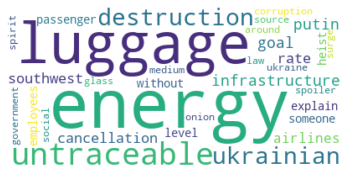

In [18]:

cluster2 = ClusterIndicesNumpy(2, model.labels_)
token_list = []
for postId in cluster2:
    post = df.iloc[postId]['title_tokens']
    for token in post:
        token_list.append(token.lower())

text = ' '.join(token_list)
wordcloud = WordCloud(background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()